In [1]:
%cat 0Source_Citation.txt

Source and citation

- This notebook is a part of the `pytheos` package.
- Website: http://github.com/SHDShim/pytheos.
- How to cite: S.-H. Shim (2017) Pytheos - a python tool set for equations of state. DOI: 10.5281/zenodo.802392


In [2]:
%matplotlib inline 
# %matplotlib notebook # for interactive

For high dpi displays.

In [3]:
%config InlineBackend.figure_format = 'retina'

# 0. General note

- This notebook shows an example of how to include anharmonic effects and/or electronic effects in the P-V-T EOS fitting.

- We use data on SiC from [Nisr et al. (2017, JGR-Planet)](http://onlinelibrary.wiley.com/doi/10.1002/2016JE005158/full).

- Note that the code here is for demonstration purpose.  In fact, we did not find any evidence for including anharmonic and electronic effects in fitting the data for SiC.  

# 1. Global setup

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import uncertainties as uct
from uncertainties import unumpy as unp
import pytheos as eos

# 2. Setup for fitting with different gold pressure scales

The equations of state of gold from Fei et al. (2007, PNAS) and Dorogokupets and Dewaele (2007, HPR).  These equations are provided in `pytheos` as built-in classes.

In [5]:
au_eos = {'Fei2007': eos.gold.Fei2007bm3(), 'Dorogokupets2007': eos.gold.Dorogokupets2007()}

Because we use Birch-Murnaghan EOS version of Fei2007 and Dorogokupets2007 used Vinet EOS, we create a dictionary to provide different static compression EOSs for the different pressure scales used.

In [6]:
st_model = {'Fei2007': eos.BM3Model, 'Dorogokupets2007': eos.VinetModel}

Assign initial values for the EOS parameters.

In [7]:
k0_3c = {'Fei2007': 241.2, 'Dorogokupets2007': 243.0}
k0p_3c = {'Fei2007': 2.84, 'Dorogokupets2007': 2.68}
k0_6h = {'Fei2007': 243.1, 'Dorogokupets2007': 245.5}
k0p_6h = {'Fei2007': 2.79, 'Dorogokupets2007': 2.59}

Also for the thermal parameters.  In this example, we will use the constant $q$ equation for the thermal part of the EOS.

In [8]:
gamma0 = 1.06
q = 1.
theta0 = 1200.

We also setup for the physical constants of two different polymorphs of SiC.

In [9]:
v0 = {'3C': 82.8042, '6H': 124.27}
n_3c = 2.; z_3c = 4.
n_6h = 2.; z_6h = 6.

# 3. Data distribution (3C)

The data set is provided in a `csv` file.

In [10]:
data = np.recfromcsv('./data/3C-HiTEOS-final.csv', case_sensitive=True, deletechars='')

Set up variables for the data.

In [11]:
v_std = unp.uarray( data['V(Au)'], data['sV(Au)'])
temp = unp.uarray(data['T(3C)'], data['sT(3C)'])
v = unp.uarray(data['V(3C)'], data['sV(3C)'])

Plot $P$-$V$-$T$ data in the $P$-$V$ and $P$-$T$ spaces.

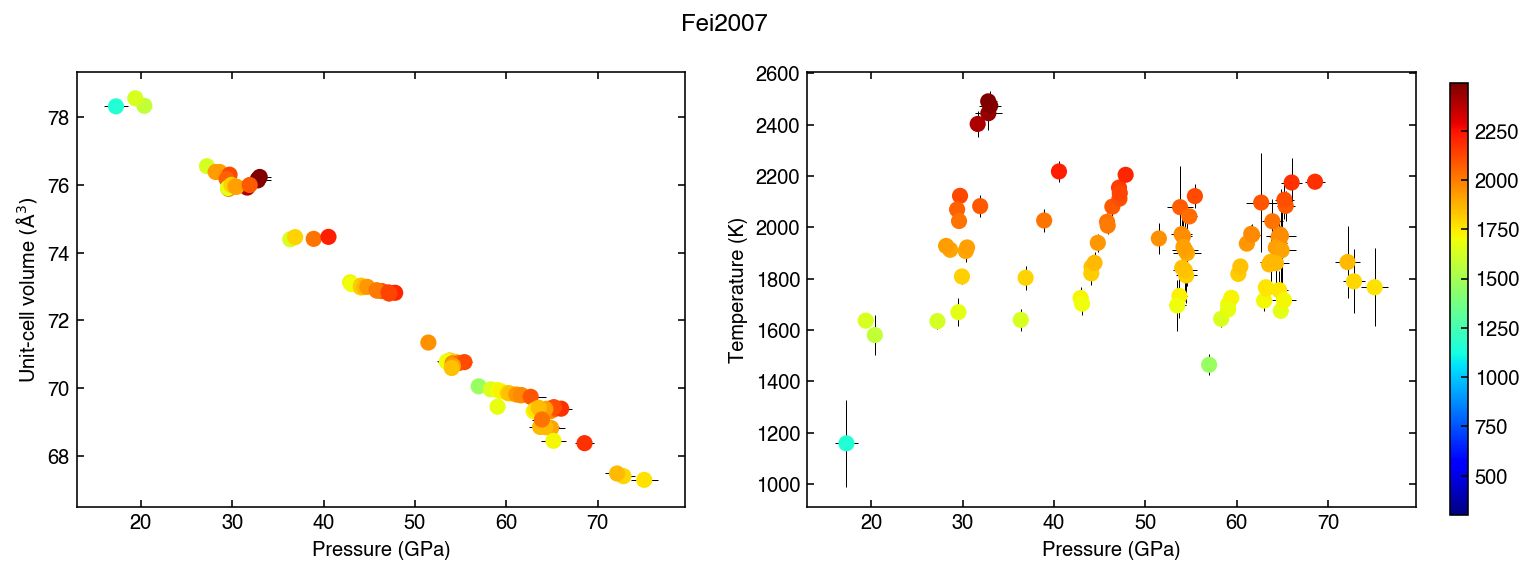

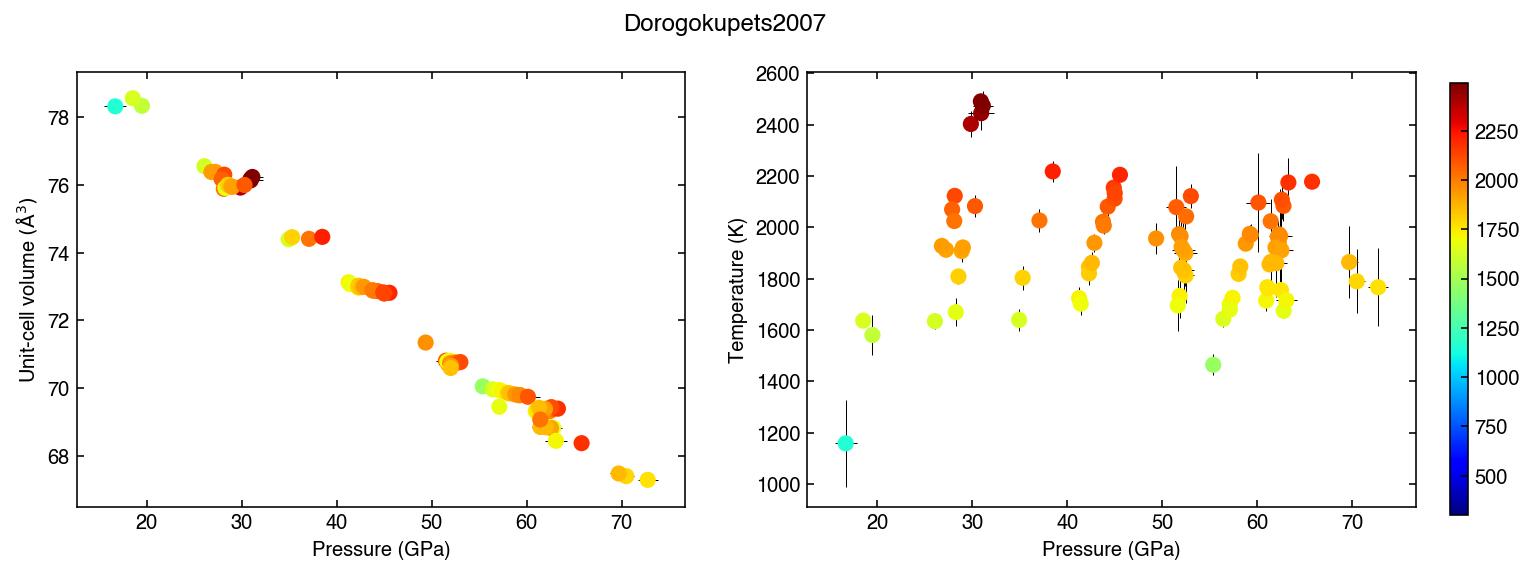

In [12]:
for key, value in au_eos.items():
    p = au_eos[key].cal_p(v_std, temp)
    eos.plot.thermal_data({'p': p, 'v': v, 'temp': temp}, title=key)

# 4. Data fitting with constq equation (3C) with electronic effects

Normally weight for each data point can be calculated from $\sigma(P)$.  In this case, using `uncertainties`, we can easily propagate the temperature and volume uncertainties to get the value.

/Users/DanShim/anaconda/envs/py35/lib/python3.5/site-packages/lmfit/model.py:684: UserWarning: The keyword argument temp does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)


********Fei2007
[[Model]]
    ((Model(bm3_p, prefix='st_') + Model(constq_pth, prefix='th_', n='2.0', z='4.0')) + Model(zharkov_pel, prefix='el_', n='2.0', z='4.0'))
[[Variables]]
    st_v0:       82.8042 (fixed)
    st_k0:       241.2 (fixed)
    st_k0p:      2.84 (fixed)
    th_v0:       82.8042 (fixed)
    th_gamma0:   1.06 (fixed)
    th_q:        1 (fixed)
    th_theta0:   1200 (fixed)
    el_v0:       82.8042 (fixed)
    el_e0:       1.67947989 +/- 2.27e+04 (1350886.70%) (init= 1e-07)
    el_g:        0.00013556 +/- 1.851977 (1366169.92%) (init= 0.01)
[[Correlations]] (unreported correlations are <  0.100)
    C(el_e0, el_g)               = -1.000 



/Users/DanShim/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


********Dorogokupets2007
[[Model]]
    ((Model(vinet_p, prefix='st_') + Model(constq_pth, prefix='th_', n='2.0', z='4.0')) + Model(zharkov_pel, prefix='el_', n='2.0', z='4.0'))
[[Variables]]
    st_v0:       82.8042 (fixed)
    st_k0:       243 (fixed)
    st_k0p:      2.68 (fixed)
    th_v0:       82.8042 (fixed)
    th_gamma0:   1.06 (fixed)
    th_q:        1 (fixed)
    th_theta0:   1200 (fixed)
    el_v0:       82.8042 (fixed)
    el_e0:       0.01091758 +/- 387.3090 (3547569.28%) (init= 1e-07)
    el_g:        0.00092769 +/- 35.78867 (3857833.87%) (init= 0.01)
[[Correlations]] (unreported correlations are <  0.100)
    C(el_e0, el_g)               = -1.000 



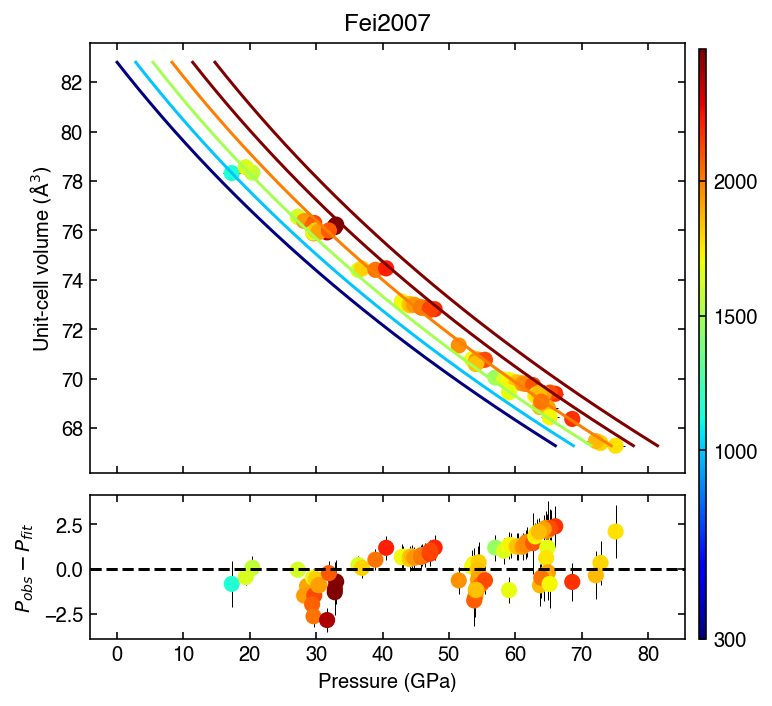

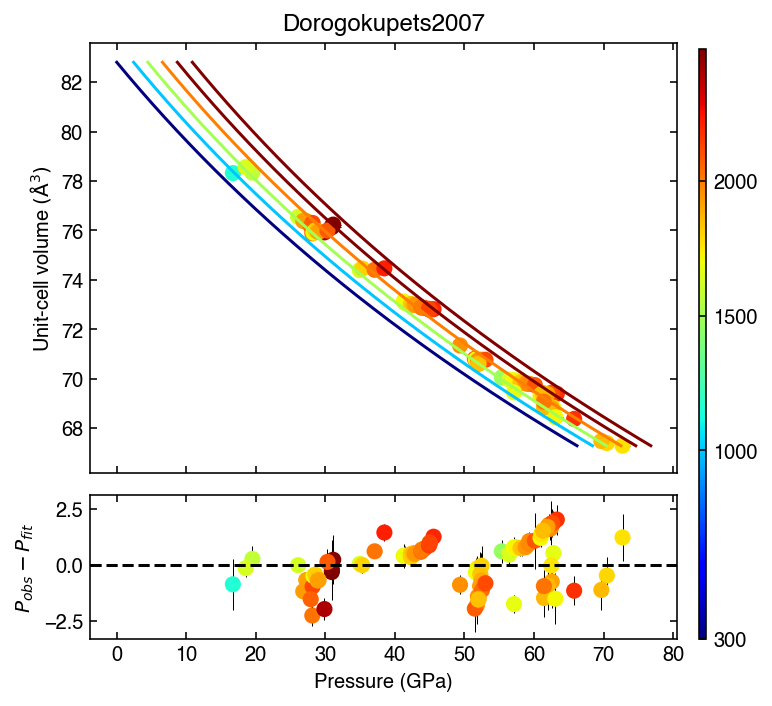

In [13]:
for key, value in au_eos.items():
    # calculate pressure
    p = au_eos[key].cal_p(v_std, temp)
    # add prefix to the parameters.  this is important to distinguish thermal and static parameters
    eos_st = st_model[key](prefix='st_') 
    eos_th = eos.ConstqModel(n_3c, z_3c, prefix='th_')
    eos_el = eos.ZharkovElecModel(n_3c, z_3c, prefix='el_')
    # define initial values for parameters
    params = eos_st.make_params(v0=v0['3C'], k0=k0_3c[key], k0p=k0p_3c[key])
    params += eos_th.make_params(v0=v0['3C'], gamma0=gamma0, q=q, theta0=theta0)
    params += eos_el.make_params(v0=v0['3C'], e0=0.1e-6, g=0.01)
    # construct PVT eos
    pvteos = eos_st + eos_th + eos_el
    # fix static parameters and some other well known parameters
    params['th_v0'].vary=False; params['th_gamma0'].vary=False; params['th_theta0'].vary=False
    params['th_q'].vary=False
    params['st_v0'].vary=False; params['st_k0'].vary=False; params['st_k0p'].vary=False
    params['el_v0'].vary=False#; params['el_e0'].vary=False#; params['el_g'].vary=False
    # calculate weights.  setting it None results in unweighted fitting
    weights = 1./unp.std_devs(p) #None
    fit_result = pvteos.fit(unp.nominal_values(p), params, v=unp.nominal_values(v), 
                                   temp=unp.nominal_values(temp), weights=weights)
    print('********'+key)
    print(fit_result.fit_report())
    # plot fitting results
    eos.plot.thermal_fit_result(fit_result, p_err=unp.std_devs(p), v_err=unp.std_devs(v), title=key)

# 5. Data fitting with constq equation (3C) with anharmonic effects

/Users/DanShim/anaconda/envs/py35/lib/python3.5/site-packages/lmfit/model.py:684: UserWarning: The keyword argument temp does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)


********Fei2007
[[Model]]
    ((Model(bm3_p, prefix='st_') + Model(constq_pth, prefix='th_', n='2.0', z='4.0')) + Model(zharkov_panh, prefix='anh_', n='2.0', z='4.0'))
[[Variables]]
    st_v0:       82.8042 (fixed)
    st_k0:       241.2 (fixed)
    st_k0p:      2.84 (fixed)
    th_v0:       82.8042 (fixed)
    th_gamma0:   1.06 (fixed)
    th_q:        1 (fixed)
    th_theta0:   1200 (fixed)
    anh_v0:      82.8042 (fixed)
    anh_a0:      1.69661242 +/- 2.32e+04 (1369174.05%) (init= 1e-07)
    anh_m:       0.00013419 +/- 1.858734 (1385144.25%) (init= 0.01)
[[Correlations]] (unreported correlations are <  0.100)
    C(anh_a0, anh_m)             = -1.000 



/Users/DanShim/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


********Dorogokupets2007
[[Model]]
    ((Model(vinet_p, prefix='st_') + Model(constq_pth, prefix='th_', n='2.0', z='4.0')) + Model(zharkov_panh, prefix='anh_', n='2.0', z='4.0'))
[[Variables]]
    st_v0:       82.8042 (fixed)
    st_k0:       243 (fixed)
    st_k0p:      2.68 (fixed)
    th_v0:       82.8042 (fixed)
    th_gamma0:   1.06 (fixed)
    th_q:        1 (fixed)
    th_theta0:   1200 (fixed)
    anh_v0:      82.8042 (fixed)
    anh_a0:      0.01107823 +/- 407.1757 (3675455.81%) (init= 1e-07)
    anh_m:       0.00091504 +/- 35.70193 (3901695.28%) (init= 0.01)
[[Correlations]] (unreported correlations are <  0.100)
    C(anh_a0, anh_m)             = -1.000 



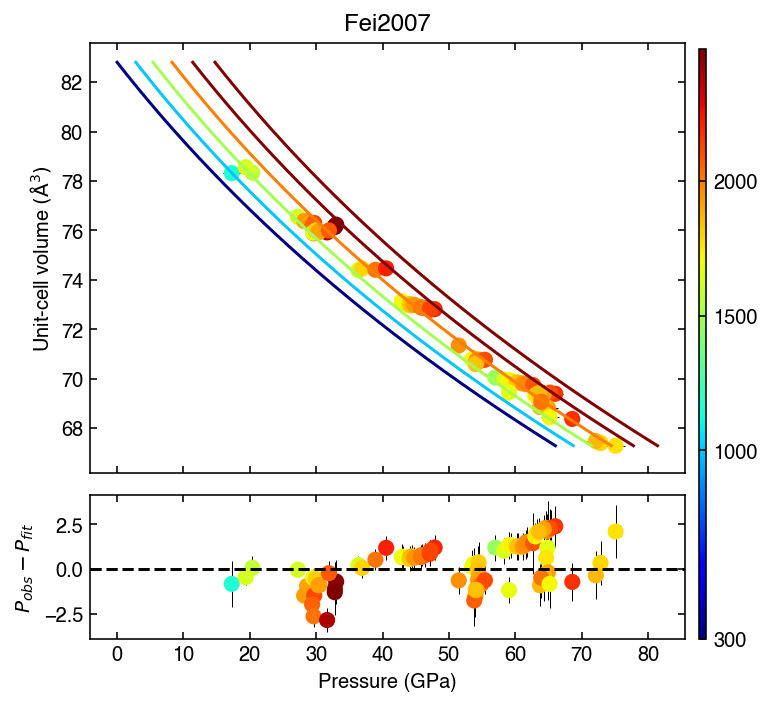

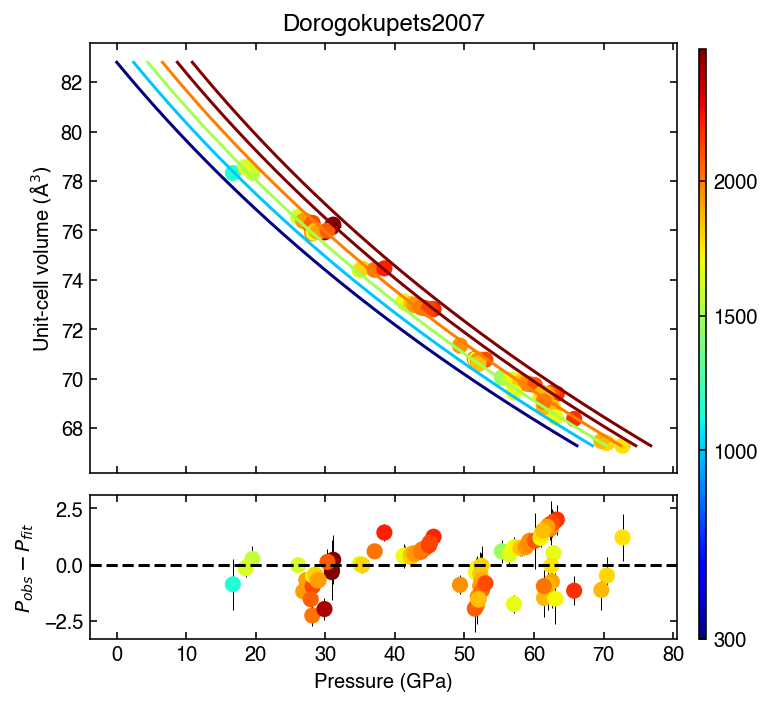

In [14]:
for key, value in au_eos.items():
    # calculate pressure
    p = au_eos[key].cal_p(v_std, temp)
    # add prefix to the parameters.  this is important to distinguish thermal and static parameters
    eos_st = st_model[key](prefix='st_') 
    eos_th = eos.ConstqModel(n_3c, z_3c, prefix='th_')
    eos_anh = eos.ZharkovAnhModel(n_3c, z_3c, prefix='anh_')
    # define initial values for parameters
    params = eos_st.make_params(v0=v0['3C'], k0=k0_3c[key], k0p=k0p_3c[key])
    params += eos_th.make_params(v0=v0['3C'], gamma0=gamma0, q=q, theta0=theta0)
    params += eos_anh.make_params(v0=v0['3C'], a0=0.1e-6, m=0.01)
    # construct PVT eos
    pvteos = eos_st + eos_th + eos_anh
    # fix static parameters and some other well known parameters
    params['th_v0'].vary=False; params['th_gamma0'].vary=False; params['th_theta0'].vary=False
    params['th_q'].vary=False
    params['st_v0'].vary=False; params['st_k0'].vary=False; params['st_k0p'].vary=False
    params['anh_v0'].vary=False#; params['el_e0'].vary=False#; params['el_g'].vary=False
    # calculate weights.  setting it None results in unweighted fitting
    weights = 1./unp.std_devs(p) #None
    fit_result = pvteos.fit(unp.nominal_values(p), params, v=unp.nominal_values(v), 
                                   temp=unp.nominal_values(temp), weights=weights)
    print('********'+key)
    print(fit_result.fit_report())
    # plot fitting results
    eos.plot.thermal_fit_result(fit_result, p_err=unp.std_devs(p), v_err=unp.std_devs(v), title=key)